In [2]:
from almanac.data.data import pd_readcsv
from almanac.analysis.calculate_returns import calculate_perc_returns
from almanac.utils.utils import *
from almanac.analysis.calculate_stats import Stats

In [2]:
data=pd_readcsv(filename='../sample_data/jumbo/SP500_micro.csv')
data

,Unnamed: 0,adjusted,underlying
1982-09-14,0,438.15,123.70
1982-09-15,1,438.65,124.20
1982-09-16,2,438.00,123.55
1982-09-17,3,437.10,122.65
1982-09-20,4,437.90,123.45
...,...,...,...
2022-12-22,10431,3847.50,3847.50
2022-12-23,10432,3868.50,3868.50
2022-12-27,10433,3856.25,3856.25
2022-12-28,10434,3810.50,3810.50


In [3]:
adjusted_price = data.adjusted
current_price = data.underlying
multiplier = 5
fx_series = pd.Series(1, index=data.index)  
position_contracts_held = pd.Series(1, index=data.index)  

capital_required = multiplier * current_price 

## Strategy 4

In [3]:
import pandas as pd
from almanac.data.data import get_data_dict
from almanac.config.instruments import *
from almanac.analysis.calculate_returns import calculate_returns
from almanac.utils.utils import *
from almanac.analysis.calculate_stats import Stats
from almanac.utils.standardDeviation import standardDeviation
from almanac.utils.fx_series import create_fx_series_given_adjusted_prices_dict
from almanac.analysis.std_for_risk import calculate_variable_standard_deviation_for_risk_targeting_from_dict
from almanac.analysis.positions import calculate_position_series_given_variable_risk_for_dict
from almanac.analysis.calculate_returns import calculate_perc_returns_for_dict
from almanac.config.instruments import *
import quantstats as qs

In [5]:
adjusted_prices, current_prices = get_data_dict('../sample_data/jumbo/',INSTRUMENT_LIST)



fx_series_dict = create_fx_series_given_adjusted_prices_dict('../sample_data/fx_data/',adjusted_prices)
risk_target_tau= 0.2
capital = 1000000
idm = 1.5

std_dev_dict = calculate_variable_standard_deviation_for_risk_targeting_from_dict(
    adjusted_prices=adjusted_prices,
    current_prices=current_prices,
    annualise_stdev=True,  ## can also be False if want to use daily price diff
    use_perc_returns=True,  ## can also be False if want to use daily price diff
)

position_contracts_dict = calculate_position_series_given_variable_risk_for_dict(
    capital=capital,
    risk_target_tau=risk_target_tau,
    idm=idm,
    weights=instrument_weights,
    std_dev_dict=std_dev_dict,
    fx_series_dict=fx_series_dict,
    multipliers=multipliers,
)

pre_cost_portfolio_returns,post_cost_portfoilio_returns = calculate_returns(position_contracts=position_contracts_dict,
                                     adjusted_prices = adjusted_prices,
                                     multipliers = multipliers,
                                     fx_series = fx_series_dict,
                                     capital = capital,
                                     cost_per_contract = cost_per_contract_dict,
                                     std_dev = std_dev_dict,
                                     aggregate= True)

                            Strategy
--------------------------  ----------
Start Period                1970-02-06
End Period                  2022-12-30
Risk-Free Rate              0.0%
Time in Market              100.0%

Cumulative Return           256.43%
Pre-Cost Cumulative Return  296.53%
CAGR﹪                      1.67%

Post-cost Sharpe            0.46
Pre-Cost Sharpe             0.5
Cost in Sharpe              0.04
Prob. Sharpe Ratio          100.0%
Smart Sharpe                0.43
Sortino                     0.85
Smart Sortino               0.79
Sortino/√2                  0.6
Smart Sortino/√2            0.56
Omega                       1.12

Max Drawdown                -22.48%
Longest DD Days             3614
Volatility (ann.)           5.08%
Calmar                      0.07
Skew                        32.28
Kurtosis                    2570.36

Expected Daily %            0.01%
Expected Monthly %          0.2%
Expected Yearly %           2.43%
Kelly Criterion             5.84

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-08,2022-12-28,2022-12-30,418,-22.475225,-21.665858
2,2014-06-27,2016-01-21,2017-11-01,1224,-12.583813,-11.574269
3,1980-02-12,1985-02-25,1990-01-03,3614,-11.386278,-10.882760
4,2008-03-17,2008-10-24,2009-11-10,604,-9.440926,-9.192519
5,2020-01-06,2020-03-18,2020-07-05,182,-8.979251,-8.622115


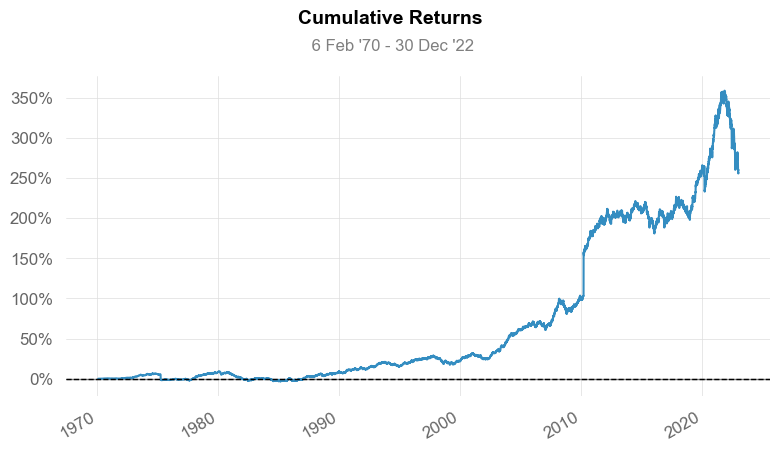

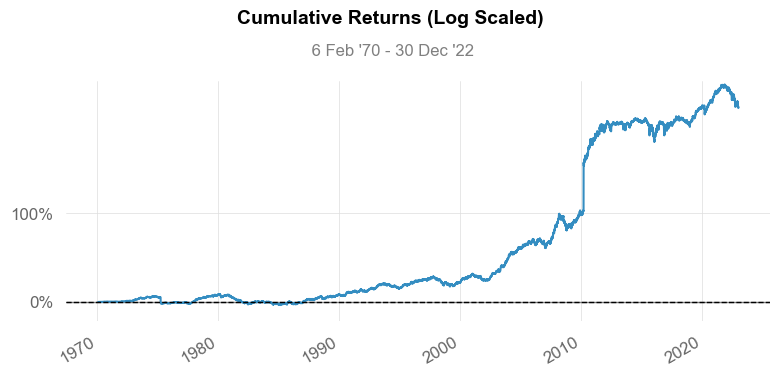

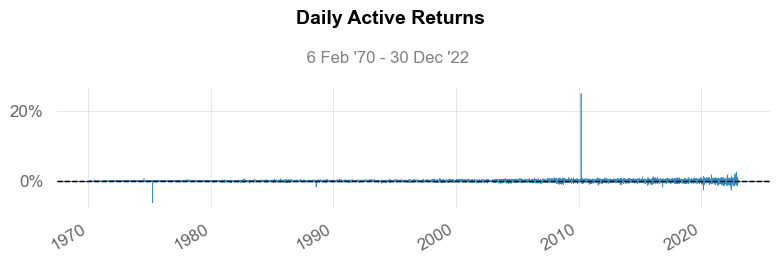

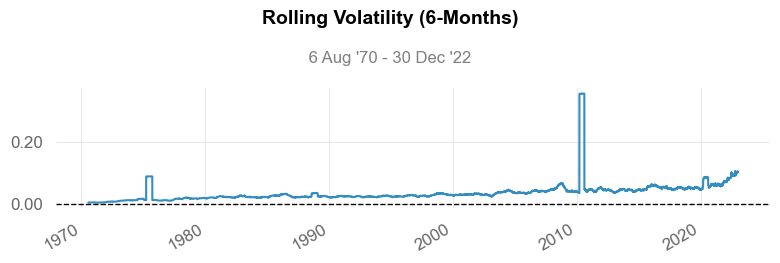

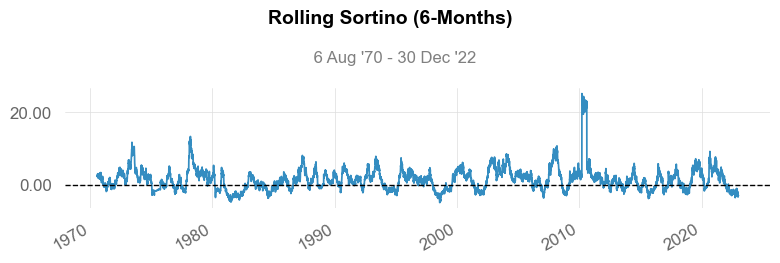

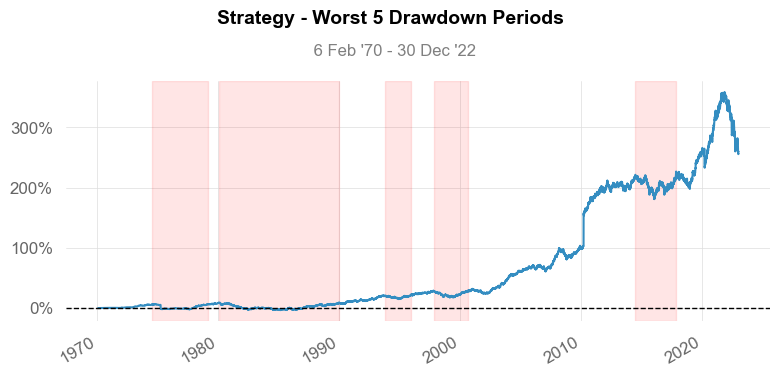

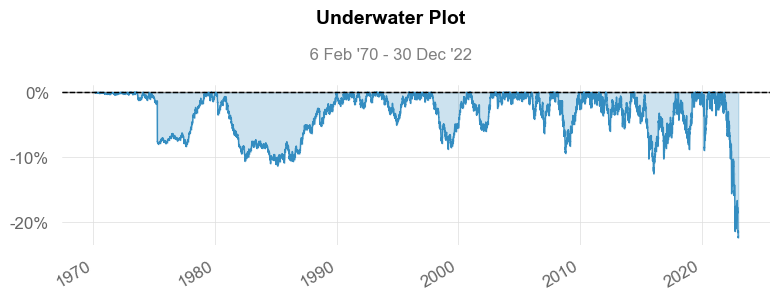

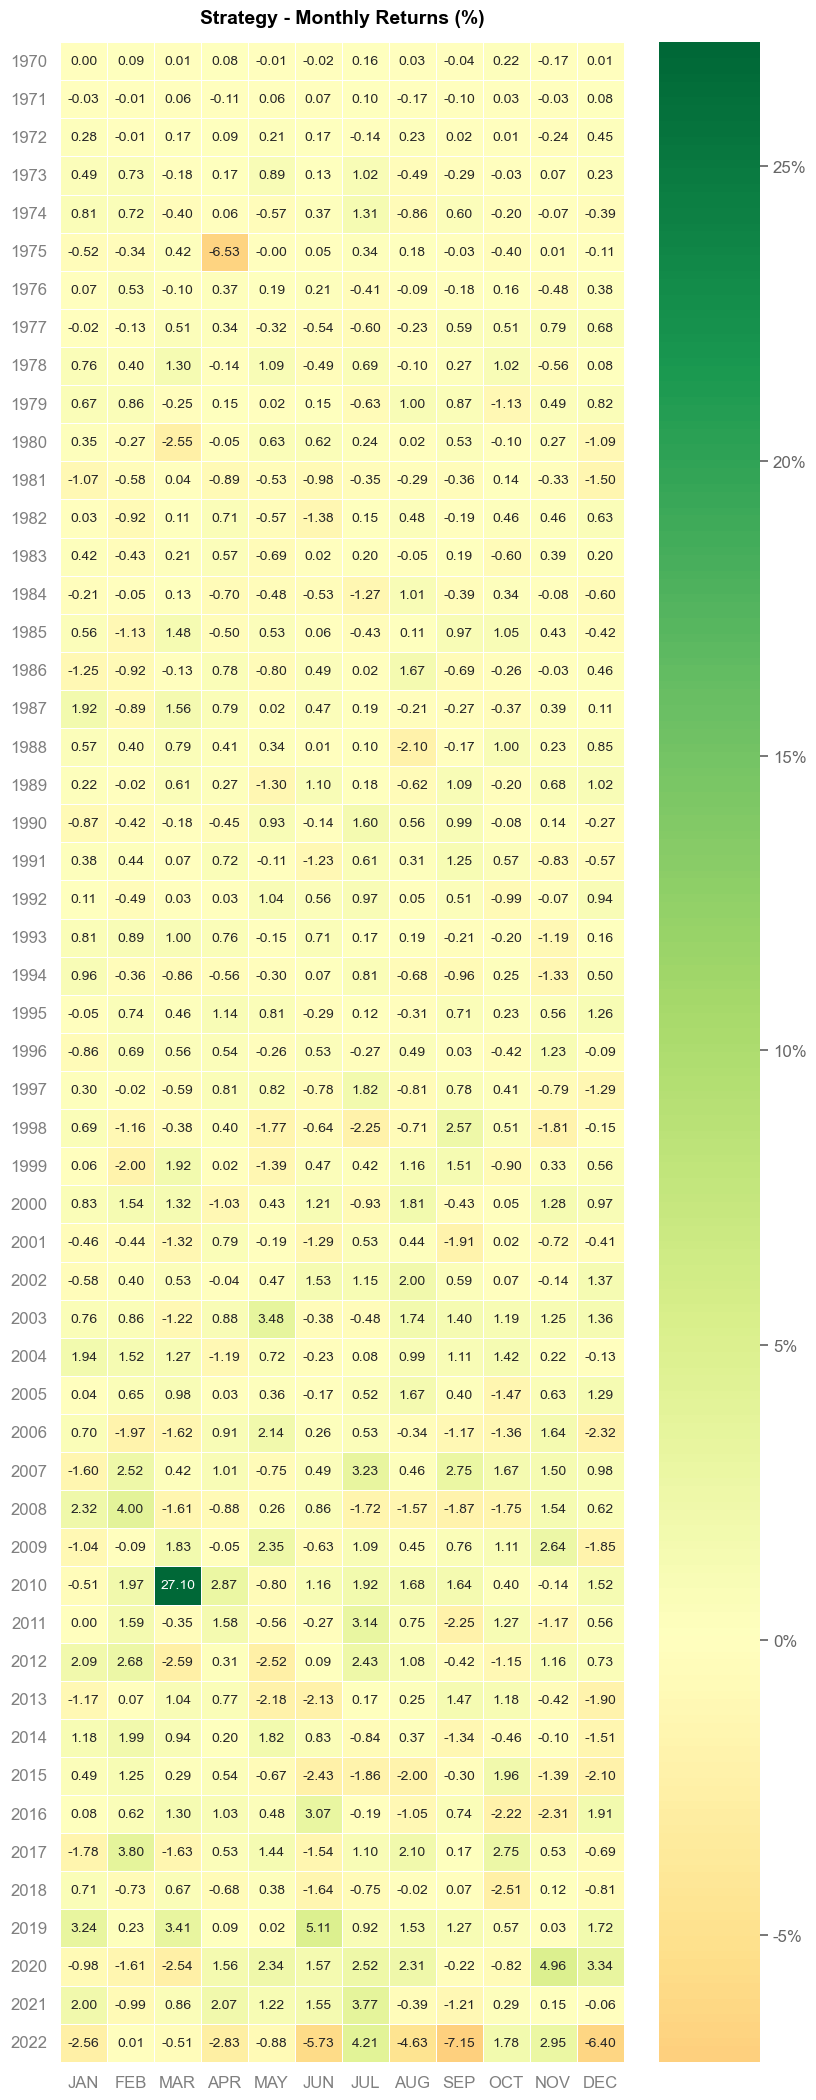

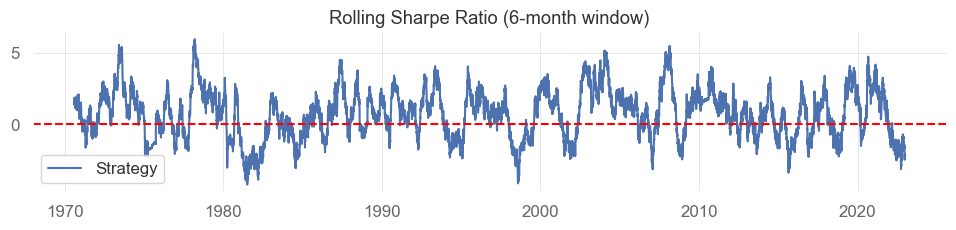

In [6]:
qs.reports.full(precost_returns=pre_cost_portfolio_returns,postcost_returns= post_cost_portfoilio_returns)

## Strategy 13

In [1]:
from almanac.config.instruments import INSTRUMENT_LIST, instrument_weights, multipliers, cost_per_contract_dict
from almanac.data.data import get_data_dict_with_carry
from almanac.analysis.positions_13 import calculate_position_dict_with_forecast_and_vol_scalar_applied
from almanac.analysis.buffering import apply_buffering_to_position_dict

In [4]:
(
    adjusted_prices_dict,
    current_prices_dict,
    carry_prices_dict,
) = get_data_dict_with_carry('../sample_data/jumbo/','../sample_data/jumbo_carry/',INSTRUMENT_LIST)
multipliers = multipliers
risk_target_tau = 0.2
fx_series_dict = create_fx_series_given_adjusted_prices_dict('../sample_data/fx_data/',adjusted_prices_dict)
capital = 1000000
idm = 1.5
instrument_weights = instrument_weights
cost_per_contract_dict = cost_per_contract_dict

std_dev_dict = calculate_variable_standard_deviation_for_risk_targeting_from_dict(
        adjusted_prices=adjusted_prices_dict, current_prices=current_prices_dict
    )
average_position_contracts_dict = (
    calculate_position_series_given_variable_risk_for_dict(
        capital=capital,
        risk_target_tau=risk_target_tau,
        idm=idm,
        weights=instrument_weights,
        std_dev_dict=std_dev_dict,
        fx_series_dict=fx_series_dict,
        multipliers=multipliers,
    )
)
rules_spec = [
        dict(function="carry", span=60),
        dict(function="ewmac", fast_span=16),
        dict(function="ewmac", fast_span=32),
        dict(function="ewmac", fast_span=64),
]

position_contracts_dict = (
        calculate_position_dict_with_forecast_and_vol_scalar_applied(
            adjusted_prices_dict=adjusted_prices_dict,
            carry_prices_dict=carry_prices_dict,
            std_dev_dict=std_dev_dict,
            average_position_contracts_dict=average_position_contracts_dict,
            rule_spec=rules_spec,
        )
)

buffered_position_dict = apply_buffering_to_position_dict(
        position_contracts_dict=position_contracts_dict,
        average_position_contracts_dict=average_position_contracts_dict,
)

pre_cost_portfolio_returns,post_cost_portfoilio_returns = calculate_returns(position_contracts=buffered_position_dict,
                                     adjusted_prices = adjusted_prices_dict,
                                     multipliers = multipliers,
                                     fx_series = fx_series_dict,
                                     capital = capital,
                                     cost_per_contract = cost_per_contract_dict,
                                     std_dev = std_dev_dict,
                                     aggregate= True)


                            Strategy
--------------------------  ----------
Start Period                1970-02-05
End Period                  2022-12-30
Risk-Free Rate              0.0%
Time in Market              98.0%

Cumulative Return           719.83%
Pre-Cost Cumulative Return  804.91%
CAGR﹪                      2.78%

Post-cost Sharpe            0.51
Pre-Cost Sharpe             0.54
Cost in Sharpe              0.02
Prob. Sharpe Ratio          100.0%
Smart Sharpe                0.49
Sortino                     1.28
Smart Sortino               1.21
Sortino/√2                  0.9
Smart Sortino/√2            0.85
Omega                       1.22

Max Drawdown                -21.09%
Longest DD Days             1802
Volatility (ann.)           7.67%
Calmar                      0.13
Skew                        65.25
Kurtosis                    6318.23

Expected Daily %            0.01%
Expected Monthly %          0.33%
Expected Yearly %           4.05%
Kelly Criterion             9.8

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-24,2019-03-01,2022-12-30,1802,-21.092949,-20.566679
2,2015-08-10,2016-11-04,2017-01-25,535,-8.181575,-6.991430
3,2013-05-20,2013-10-09,2013-12-23,218,-7.509052,-6.822209
4,2007-02-21,2007-10-09,2008-11-10,629,-7.116656,-6.872954
5,2009-02-24,2009-08-07,2009-11-30,280,-6.543740,-6.197593


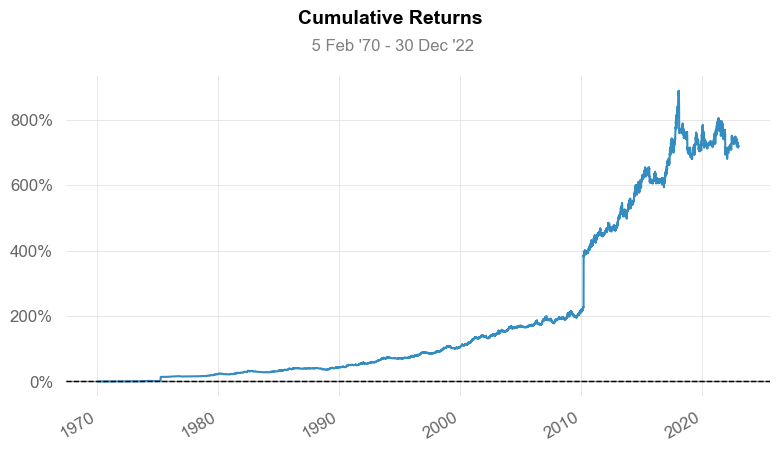

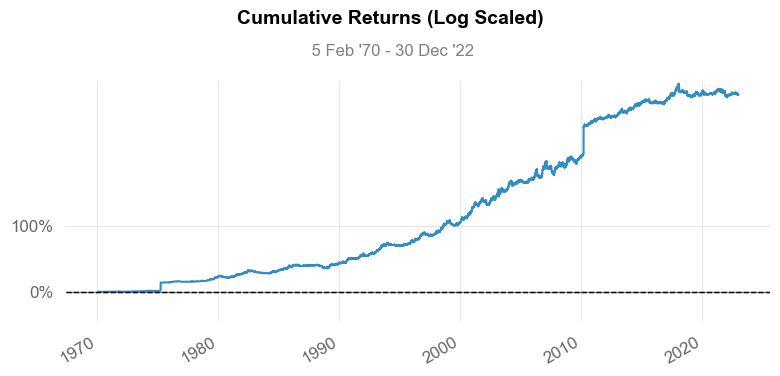

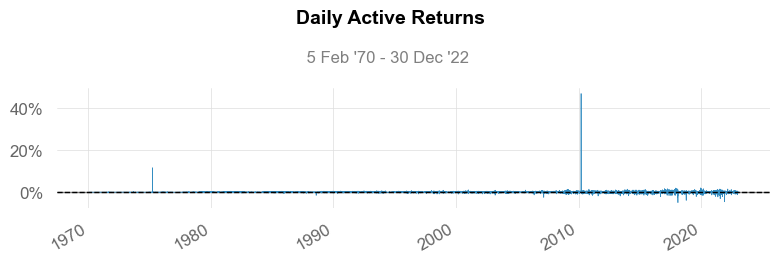

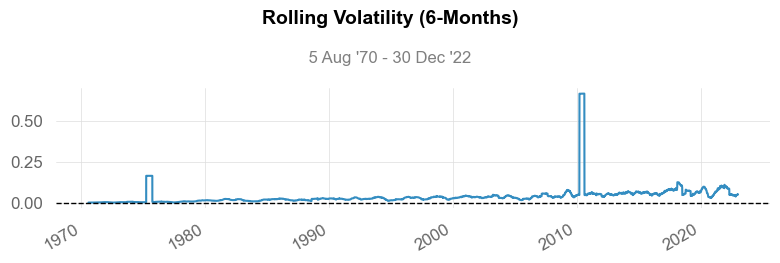

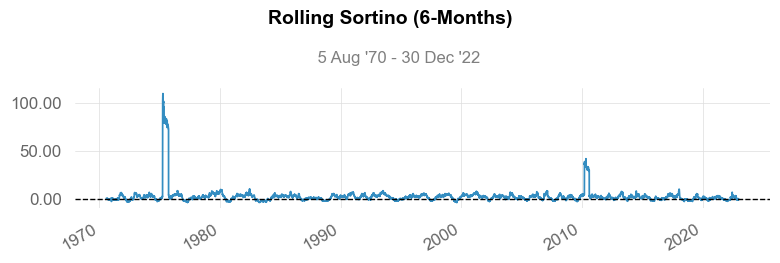

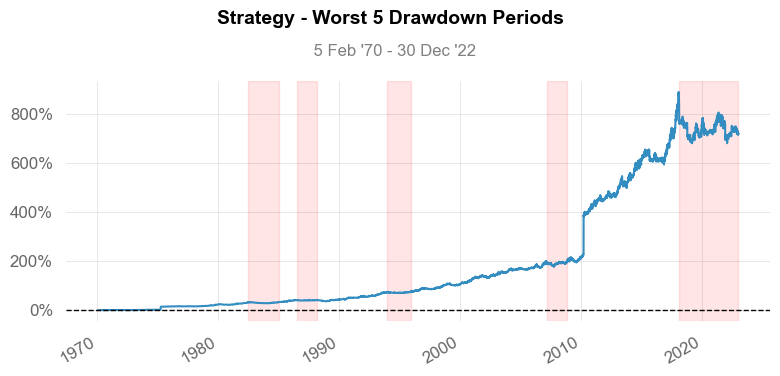

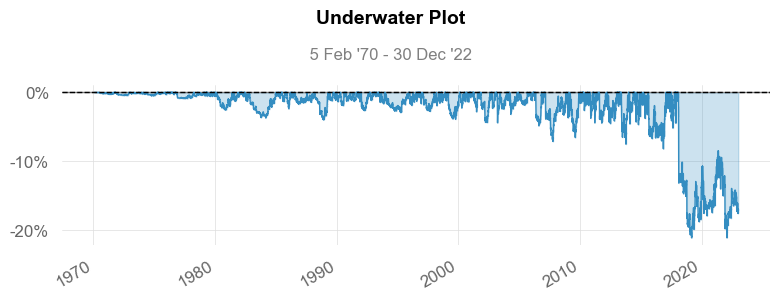

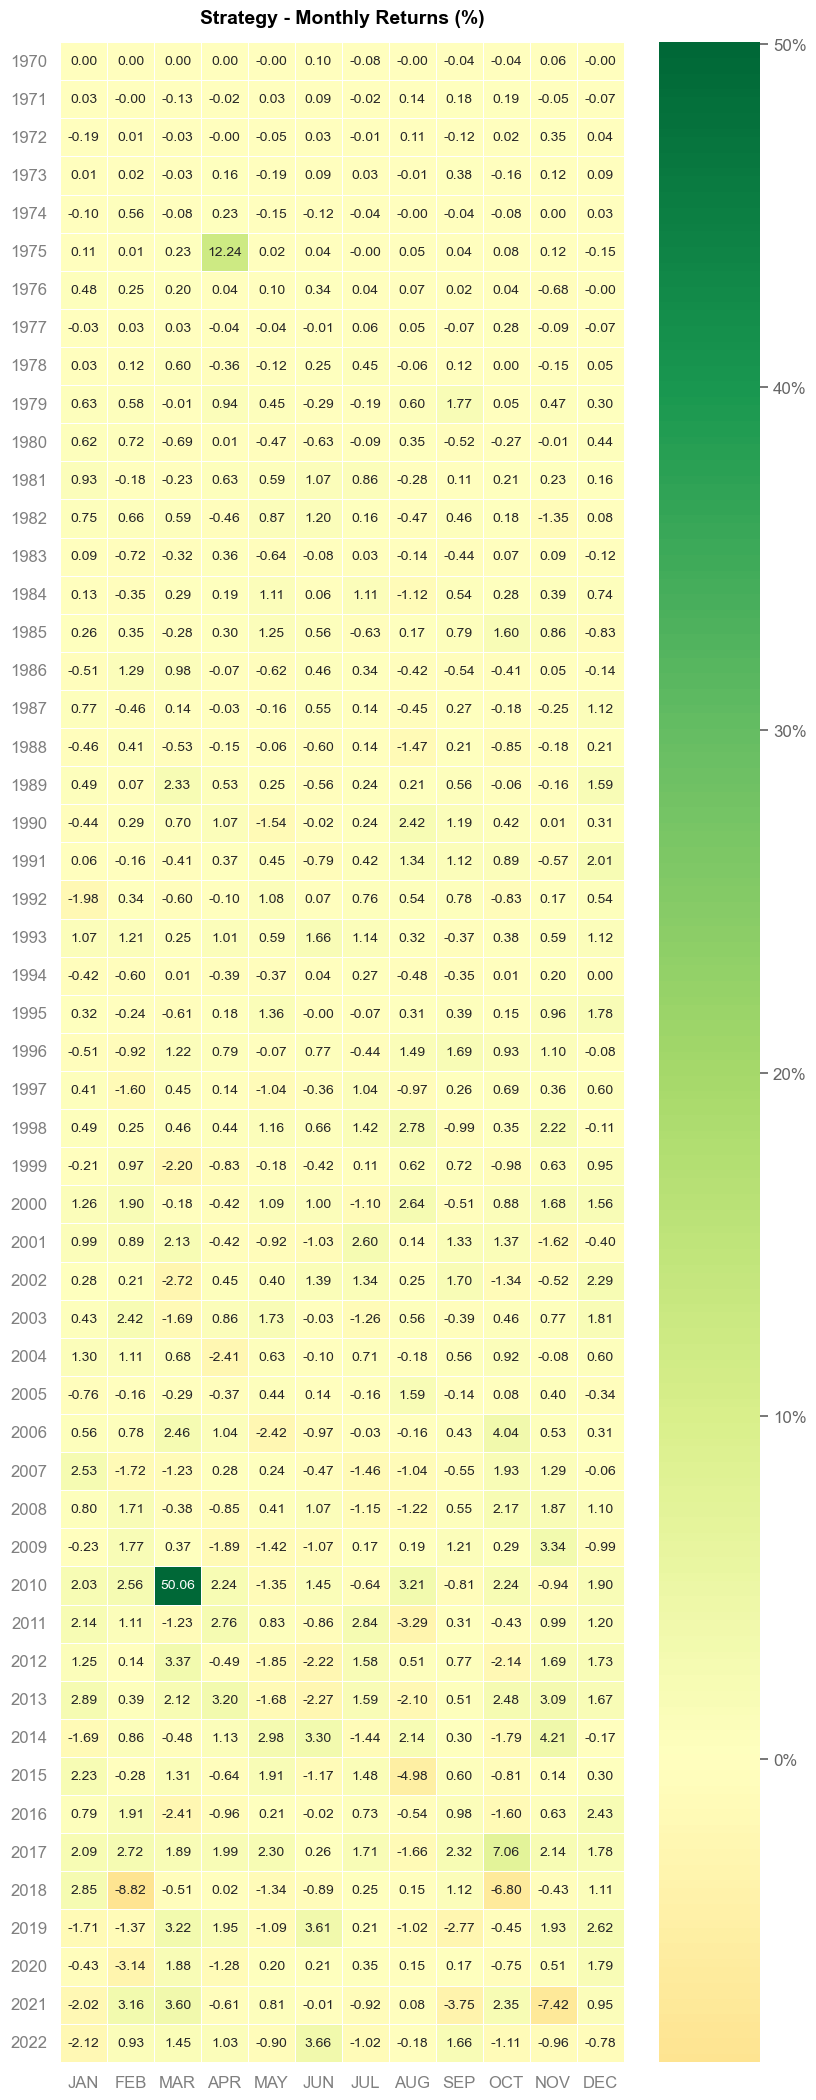

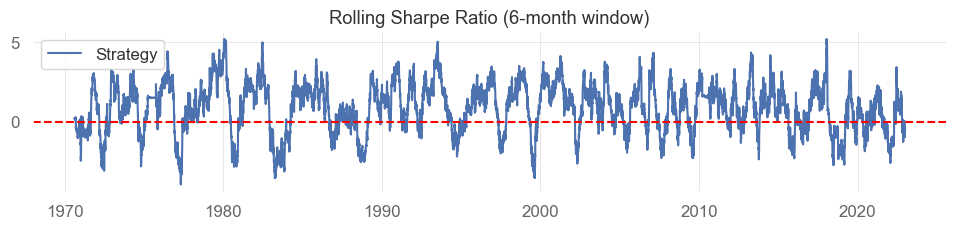

In [5]:
qs.reports.full(precost_returns=pre_cost_portfolio_returns,postcost_returns= post_cost_portfoilio_returns)